<a href="https://colab.research.google.com/github/MojTabaa4/POS-Tagging-and-Named-Entity-Recognition-with-RNNs/blob/main/POS_NER_with_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [23]:
import os
import random
import time
from collections import Counter, defaultdict
from typing import List, Tuple

import keras
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from gensim.models import KeyedVectors, Word2Vec
from keras.layers import (GRU, LSTM, RNN, Bidirectional, Dense, Dropout,
                          Embedding, Input, Masking, SimpleRNN,
                          SpatialDropout1D, TimeDistributed)
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from nltk.chunk import conlltags2tree, tree2conlltags
from nltk.corpus import treebank
from nltk.tokenize import word_tokenize
from nltk.tree import Tree
from sklearn.model_selection import train_test_split
from tensorflow.keras import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


In [ ]:
class PTBPosLoader:
    """
    A class for loading and preprocessing the Penn Treebank Part of Speech dataset.
    """

    def __init__(self, use_universal_tag_set: bool = True, test_size: float = 0.1, val_size: float = 0.1):
        """
        Initializes the PTBPosLoader object.

        Args:
            use_universal_tag_set (bool): Whether to use the universal tag set. Default is True.
            test_size (float): The proportion of the dataset to use for testing. Default is 0.1.
            val_size (float): The proportion of the training set to use for validation. Default is 0.1.
        """
        if use_universal_tag_set:
            self.ptb = list(treebank.tagged_sents(tagset='universal'))
        else:
            self.ptb = list(treebank.tagged_sents())

        self.test_size = test_size
        self.val_size = val_size
        self._split_train_val_test_sets()
        self._extract_all_word_tag_pairs()

    def _split_train_val_test_sets(self) -> None:
        """
        Splits the dataset into training, validation, and testing sets.
        """
        self.train_set, self.test_set = train_test_split(self.ptb,
                                                         test_size=self.test_size,
                                                         random_state=100)
        self.train_set, self.val_set = train_test_split(self.train_set,
                                                        test_size=self.val_size,
                                                        random_state=100)

    def _extract_all_word_tag_pairs(self) -> None:
        """
        Extracts all word-tag pairs from the training, validation, and testing sets.
        """
        self.train_word_tag_pairs = [word_tag for record in self.train_set for word_tag in record]
        self.val_word_tag_pairs = [word_tag for record in self.val_set for word_tag in record]
        self.test_word_tag_pairs = [word_tag for record in self.test_set for word_tag in record]

    def get_vocab_and_tags_set(self) -> Tuple[set, List[str]]:
        """
        Returns a tuple containing the vocabulary and tags set of the training set.

        Returns:
            A tuple containing the vocabulary (set) and tag set (list of strings) of the training set.
        """
        vocab = set([word_tag[0] for word_tag in self.train_word_tag_pairs])
        tags_set = sorted(list(set([pair[1] for pair in self.train_word_tag_pairs])))

        return vocab, tags_set

    def get_train_val_test_sets(self) -> Tuple[
        List[List[Tuple[str, str]]], List[List[Tuple[str, str]]], List[List[Tuple[str, str]]]]:
        """
        Returns a tuple containing the training, validation, and testing sets.

        Returns:
            A tuple containing the training, validation, and testing sets, each as a list of sentences, where each sentence
            is a list of word-tag pairs (tuples).
        """
        return self.train_set, self.val_set, self.test_set


In [ ]:
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

Number of examples in train and test sets combined: 3561
Number of examples in train set: 3169
Number of examples in test set: 392
[('One', 'NUM'), ('clear', 'ADJ'), ('sign', 'NOUN'), ('of', 'ADP'), ('Japan', 'NOUN'), ("'s", 'PRT'), ('nervousness', 'NOUN'), ('came', 'VERB'), ('this', 'DET'), ('week', 'NOUN'), (',', '.'), ('when', 'ADV'), ('a', 'DET'), ('spokesman', 'NOUN'), ('for', 'ADP'), ('Japan', 'NOUN'), ("'s", 'PRT'), ('Foreign', 'NOUN'), ('Ministry', 'NOUN'), ('devoted', 'VERB'), ('nearly', 'ADV'), ('all', 'DET'), ('of', 'ADP'), ('a', 'DET'), ('regular', 'ADJ'), (',', '.'), ('half-hour', 'ADJ'), ('briefing', 'NOUN'), ('for', 'ADP'), ('foreign', 'ADJ'), ('journalists', 'NOUN'), ('to', 'PRT'), ('the', 'DET'), ('subject', 'NOUN'), ('of', 'ADP'), ('recent', 'ADJ'), ('Japanese', 'ADJ'), ('investments', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('U.S.', 'NOUN'), ('*T*-1', 'X'), ('.', '.')]
[('Buying', 'VERB'), ('for', 'ADP'), ('the', 'DET'), ('most', 'ADJ'), ('part', 'NOUN'), ('carried',

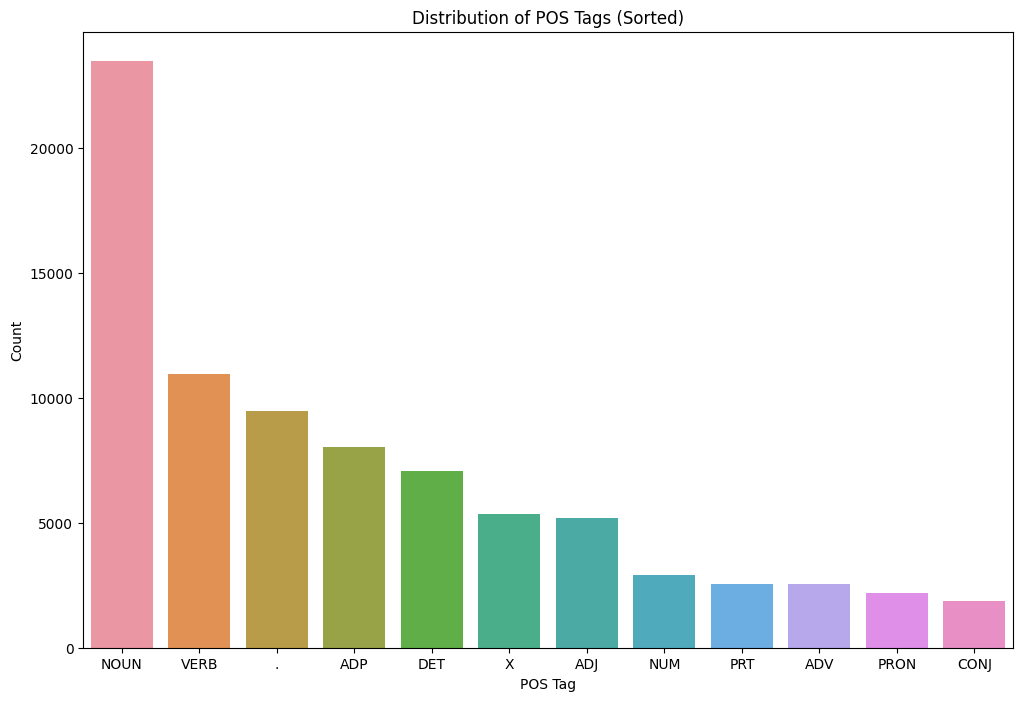

In [ ]:
loader = PTBPosLoader()
train, val, test = loader.get_train_val_test_sets()

print("Number of examples in train and test sets combined:", len(train) + len(test))
print("Number of examples in train set:", len(train))
print("Number of examples in test set:", len(test))

print(train[1])
print(test[1])

vocab, tag_set = loader.get_vocab_and_tag_set()
print("Vocabulary size:", len(vocab))
print("Number of unique POS tags:", len(tag_set))

tag_counts = {tag: 0 for tag in tag_set}

train_word_tag_pairs = [word_tag for sentence in loader.train_set for word_tag in sentence]
tag_counts = Counter(tag for word, tag in train_word_tag_pairs)

sorted_tag_counts = {k: v for k, v in sorted(tag_counts.items(), key=lambda item: item[1], reverse=True)}

plt.figure(figsize=(12, 8))
sns.barplot(x=list(sorted_tag_counts.keys()), y=list(sorted_tag_counts.values()))
plt.xlabel("POS Tag")
plt.ylabel("Count")
plt.title("Distribution of POS Tags (Sorted)")
plt.show()

# Implement Viterbi Algorithm

In [26]:
class POSTagger:
    def __init__(self, dataset_loader: PTBPosLoader, smoothing_const: float = 0.001) -> None:
        """
        Initialize the POSTagger.

        Args:
            dataset_loader: An instance of PTBPosLoader for loading the dataset.
            smoothing_const: Smoothing constant for handling out-of-vocabulary words.
        """
        self.dataset_loader = dataset_loader
        self.smoothing_const = smoothing_const
        self.emission_file_name = 'emission_ptb.csv'

        self.train_set, self.val_set, self.test_set = self.dataset_loader.get_train_val_test_sets()
        self.all_tags = [pair[1] for pair in self.dataset_loader.train_word_tag_pairs]

        self.vocab, self.tags_set = self.dataset_loader.get_vocab_and_tags_set()

        self.test_run_base: List[Tuple[str, str]] = [tup for sent in self.test_set for tup in sent]
        self.test_tagged_words: List[str] = [tup[0] for sent in self.test_set for tup in sent]

        self.tags_matrix: np.ndarray = None
        self.trans_df: pd.DataFrame = None
        self.emission_matrix: np.ndarray = None
        self.emission_df: pd.DataFrame = None

    def get_transition(self, curr_tag: str, prev_tag: str) -> float:
        """
        Calculate the transition probability between two tags.

        Args:
            curr_tag: Current tag.
            prev_tag: Previous tag.

        Returns:
            Transition probability from prev_tag to curr_tag.
        """
        count_prev_tag = len([tag for tag in self.all_tags if tag == prev_tag])
        count_prev_tag_curr_tag = sum(
            1 for i in range(len(self.all_tags) - 1)
            if self.all_tags[i + 1] == curr_tag and self.all_tags[i] == prev_tag
        )

        return count_prev_tag_curr_tag / count_prev_tag

    def set_transition_matrix(self, print_transition_matrix: bool = False) -> None:
        """
        Set the transition matrix based on the training set.

        Args:
            print_transition_matrix: Whether to print the transition matrix.
        """
        self.tags_matrix = np.zeros((len(self.tags_set), len(self.tags_set)), dtype='float32')

        for i, t1 in enumerate(list(self.tags_set)):
            for j, t2 in enumerate(list(self.tags_set)):
                self.tags_matrix[i, j] = self.get_transition(t2, t1)

        self.trans_df = pd.DataFrame(self.tags_matrix, columns=list(self.tags_set), index=list(self.tags_set))

        if print_transition_matrix:
            print(self.trans_df)

    def get_emission(self, word: str, tag: str) -> float:
        """
        Calculate the emission probability of a word given a tag.

        Args:
            word: Word.
            tag: Tag.

        Returns:
            Emission probability of the word given the tag.
        """
        pairs_with_tag = [pair for pair in self.dataset_loader.train_word_tag_pairs if pair[1] == tag]
        words_with_tag = [pair[0] for pair in pairs_with_tag if pair[0] == word[0]]

        return len(words_with_tag) / len(pairs_with_tag)

    def set_emission_matrix(self, print_emission_matrix: bool = False) -> None:
        """
        Set the emission matrix based on the training or saved matrix.

        Args:
            print_emission_matrix: Whether to print the emission matrix.
        """
        if os.path.exists(self.emission_file_name):
            self.read_emission_csv()
        else:
            self.emission_matrix = np.zeros((len(self.dataset_loader.test_word_tag_pairs), len(self.tags_set)),
                                            dtype='float32')

            for i, w in enumerate(list(self.dataset_loader.test_word_tag_pairs)):
                if i % 300 == 0:
                    print(f"round: {i}")
                for j, t2 in enumerate(list(self.tags_set)):
                    self.emission_matrix[i, j] = self.get_emission(w, t2)

            self.emission_df = pd.DataFrame(self.emission_matrix, columns=list(self.tags_set),
                                            index=list(self.dataset_loader.test_word_tag_pairs))
            self.save_emission_csv()

        if print_emission_matrix:
            print(self.emission_df)

    def save_emission_csv(self) -> None:
        """Save the emission matrix to a CSV file."""
        self.emission_df.to_csv(self.emission_file_name, index=list(self.dataset_loader.test_word_tag_pairs))

    def read_emission_csv(self) -> None:
        """Read the emission matrix from a CSV file."""
        self.emission_df = pd.read_csv(self.emission_file_name).set_index('Unnamed: 0')

    def _viterbi(self) -> List[Tuple[str, str]]:
        """
        Perform the Viterbi algorithm for tagging.
        
        Returns:
            List of tuples containing word-tag pairs.
        """
        viterbi = []
        for key, word in enumerate(self.test_tagged_words):
            max_prob = -1
            best_tag = None

            for tag in self.tags_set:
                if key == 0:
                    transition_p = self.trans_df.loc['.', tag]
                else:
                    last_state = viterbi[-1]
                    transition_p = self.trans_df.loc[last_state, tag]

                emission_p = self.emission_df.iat[key, self.tags_set.index(tag)]

                prob = emission_p * transition_p

                if prob >= max_prob:
                    max_prob = prob
                    best_tag = tag

            viterbi.append(best_tag)

        return list(zip(self.test_tagged_words, viterbi))

    def smoothed_viterbi(self) -> List[Tuple[str, str]]:
        """
        Perform the Viterbi algorithm with smoothing for tagging.

        Returns:
            List of tuples containing word-tag pairs.
        """
        viterbi = []

        for key, word in enumerate(self.test_tagged_words):
            max_prob = -1
            best_tag = None
            for tag in self.tags_set:
                if key == 0:
                    transition_p = self.trans_df.loc['.', tag]
                else:
                    last_state = viterbi[-1]
                    transition_p = self.trans_df.loc[last_state, tag]

                if word in self.vocab:
                    emission_p = self.emission_df.iat[key, self.tags_set.index(tag)]
                else:
                    emission_p = self.smoothing_const

                prob = emission_p * transition_p

                if prob >= max_prob:
                    max_prob = prob
                    best_tag = tag

            viterbi.append(best_tag)

        return list(zip(self.test_tagged_words, viterbi))

    def apply_viterbi(self, smoothing: bool = True) -> List[Tuple[str, str]]:
        """
        Apply the Viterbi algorithm for tagging.

        Args:
            smoothing: Whether to use smoothing during tagging.

        Returns:
            List of tuples containing word-tag pairs.
        """
        self.set_transition_matrix()
        self.set_emission_matrix()

        if smoothing:
            tagged_res = self.smoothed_viterbi()
        else:
            tagged_res = self._viterbi()

        return tagged_res

    def evaluate(self, tagged_res: List[Tuple[str, str]]) -> Tuple[float, List[Tuple[str, str]]]:
        """
        Evaluate the accuracy of the tagging results.

        Args:
            tagged_res: List of tuples containing word-tag pairs.

        Returns:
            Tuple of accuracy and a list of wrong predictions.
        """
        res = []
        wrong_preds = []

        for i, j in zip(tagged_res, self.test_run_base):
            if i == j:
                res.append(1)

        for _, pair in enumerate(zip(tagged_res, self.test_run_base)):
            if pair[0] != pair[1]:
                wrong_preds.append(pair)

        accuracy = len(res) / len(tagged_res)

        return accuracy, wrong_preds


In [27]:
ptb_loader = PTBPosLoader()
pos_tagger = POSTagger(ptb_loader)

viterbi_tag_res = pos_tagger.apply_viterbi()

accuracy, wrong_preds = pos_tagger.evaluate(viterbi_tag_res)

print(f"accuracy = {accuracy}")

for i in range(10):
    print(f"word: {wrong_preds[i][0][0]} | predicted: {wrong_preds[i][0][1]} | expected: {wrong_preds[i][1][1]}")


round: 0


KeyboardInterrupt: ignored